# Expectation Maximization for latent variable models

In all the notebooks we've seen so far, we have made the assumption that the observations correspond directly to realizations of a random variable. Take the case of linear regression: we are given observations of the random variable $t$ (plus some noise), which is the target value for a given value of the input $\mathbf{x}$. Under the framework of maximum likelihood estimation (MLE), we find the best parameters $\boldsymbol{\theta}$ of a model $y(\mathbf{x}, \boldsymbol{\theta})$ that is able to explain the observations and yield predictions for new inputs.

In the more general case, we have a dataset of observations $\mathcal{D} = \lbrace \mathbf{x_1}, ..., \mathbf{x_N}\rbrace$. We hypothesize that each observation is drawn from a probability distribution $p(\mathbf{x_i}\vert\boldsymbol{\theta})$  with parameters $\boldsymbol{\theta}$. It is sometimes useful to think of this as a probabilistic graphical model, where nodes represent random variables and edges encode dependency relationships between them. In this case, the graph looks as follows:

(graph here)

In this graph, we show that we have $N$ observations by enclosing the $\mathbf{x}_i$ random variables within a *plate*. This also represents the fact that we assume the observations to be independent.

For many situations this model works, that is, the model is able to explain the data and can be used to make predictions for new observations. In other cases, however, this model is not expressive enough.

Imagine that we have a single dimensional variable $x$ of which we observe some samples. Our first hypothesis is that $p(x\vert\boldsymbol{\theta})$ is a normal distribution, so we proceed to find the mean and variance of this distribution using MLE:

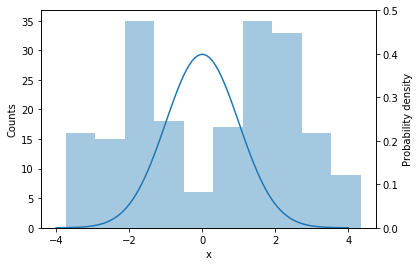

In [5]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from data.synthetic import gaussian_mixture

X = gaussian_mixture(200)
# The MLE estimates are the sample mean and standard deviation
mean = np.mean(X)
std = np.std(X)

# Plot fit on top of histogram
fig, ax1 = plt.subplots()
ax1.hist(X, alpha=0.4)
ax1.set_ylabel('Counts')
ax1.set_xlabel('x')

ax2 = ax1.twinx()
x = np.linspace(-4, 4, 100)
ax2.plot(x, norm.pdf(x))
ax2.set_ylim([0, 0.5])
ax2.set_ylabel('Probability density');

Clearly, once we have actually examined the data, we realize that a single normal distribution is not a good model. The data seems to come from a multimodal distribution with two components, which a single Gaussian is not able to capture. In this case we are better off by changing our model to a *mixture model*, a model that mixes two or more distributions. For the example above, it would seem that a mixture of two components, centered at -2 and 2 would be a better fit.

Under this idea, our hypothesis is the next: there are $K$ components in the mixture model. We start by selecting a component $k$ with some probability $\pi_k$ and, given the selected component, we then draw a sample $x$ from a normal distribution $\mathcal{N}(x\vert\mu_k, \sigma_k^2)$.

We can think of the component as a discrete random variable $z$ that can take values from 1 up to $K$. Therefore, to each sample $x$ there is an associated value of $z$. We do not observe $z$, though, so $z$ is a **latent variable**. If we collapse the parameters $\pi_k$, $\mu_k$ and $\sigma_k$ into a single parameter $\boldsymbol{\theta}$, the graphical model for the general case is now the following:

(graph here)

Note how the model emphasizes the fact that each observation has an associated value of the latent variable. Also note that since $z$ is not observed, its node is not shaded.

We can now proceed to find the parameters of our new model, using MLE (or maximum a posteriori, if we have priors on the parameters). However, as it usually is the case, we have traded tractability for expressiveness by introducing latent variables. If we attempt to maximize the log-likelihood, we find that we need to maximize

$$
\begin{align}
\sum_{n=1}^N\log \sum_{z}p(x_n\vert z_n, \boldsymbol{\theta})p(z_n\vert\boldsymbol{\theta})
\end{align}
$$

which due to the summation inside the logarithm, does not result in a closed form solution. An alternative is to use the **Expectation Maximization** algorithm, an iterative procedure that can be used to find maximum likelihood estimates of the parameters, which we motivate next.

Let $\mathbf{X}$ and $\mathbf{Z}$ denote the set of observed and latent variables, respectively, for which we have defined a joint parametric probability distribution

$$
p(\mathbf{X}, \mathbf{Z}\vert\boldsymbol{\theta}) = p(\mathbf{X}\vert\mathbf{Z},\boldsymbol{\theta})p(\mathbf{Z}\vert\boldsymbol{\theta})
$$

It can be shown [1, 2] that for any distribution $q(\mathbf{Z})$ we can decompose the log-likelihood as

$$
\log p(\mathbf{X}\vert\boldsymbol{\theta}) = \mathcal{L}(q, \boldsymbol{\theta}) + \text{KL}(q(\mathbf{Z})\Vert p(\mathbf{Z\vert\mathbf{X}, \boldsymbol{\theta}}))\tag{1}
$$

where $\text{KL}$ is the Kullback-Leibler divergence, and $\mathcal{L}(q,\boldsymbol{\theta})$ is known as the Evidence Lower Bound (ELBO), because since the KL divergence is always non-negative, it is a lower bound for $p(\mathbf{X}\vert\boldsymbol{\theta})$. The ELBO is defined as

$$
\mathcal{L}(q, \boldsymbol{\theta}) = \mathbb{E}_q[\log p(\mathbf{X},\mathbf{Z}\vert\boldsymbol{\theta})] - \mathbb{E}_q[\log q(\mathbf{Z})]\tag{2}
$$

Note that these expectations are taken with respect to the distribution $q(\mathbf{Z})$.

We can now use this decomposition in the EM algorithm to define two steps:

- **E step:** Initialize the parameters with some value $\boldsymbol{\theta}^\prime$. In equation 1, close the gap between the lower bound and the likelihood by making the KL divergence equal to zero. We achieve this by setting $q(\mathbf{Z})$ equal to the posterior $p(\mathbf{Z}\vert\mathbf{X},\boldsymbol{\theta}^\prime)$, which usually involves using Bayes' theorem to calculate

  $$
  p(\mathbf{Z}\vert\mathbf{X},\boldsymbol{\theta}^\prime) =
  \frac{p(\mathbf{X}\vert\mathbf{Z},\boldsymbol{\theta}^\prime)p(\mathbf{Z}\vert\boldsymbol{\theta}^\prime)}{p(\mathbf{X}\vert\boldsymbol{\theta}^\prime)}
  $$

- **M step:** now that the likelihood is equal to the lower bound, maximize the lower bound in equation 2 with respect to the parameters. We find

  $$
  \boldsymbol{\theta}^{\text{new}} = \arg\max_{\boldsymbol{\theta}} \mathbb{E}_q[\log p(\mathbf{X},\mathbf{Z}\vert\boldsymbol{\theta})]
  $$

  where we have dropped the second term in equation 2 as it does not depend on the parameters, and the expectation is calculated with respect to $q(\mathbf{Z}) = p(\mathbf{Z}\vert\mathbf{X},\boldsymbol{\theta}^\prime)$. In this step we calculate the derivatives with respect to the parameters and set them to zero to find the maximizing values.

This process is repeated until convergence.

## A practical example

We will use this idea to fit a mixture model from a subset of the famous MNIST dataset. In this dataset each image is of size 28 by 28, containing a handwritten number between 0 and 9, although for simplicity we will take only the digits 4, 5, and 2.

We will process the images so that they are binary, so that a pixel can be either 1 or 0. The images are flattened, so that a digit is represented by a vector of 28 $\times$ 28 = 784 values.

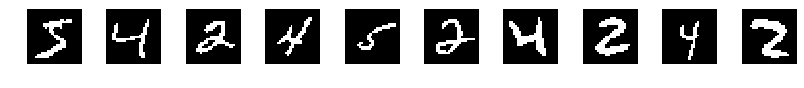

In [6]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Fetch data from OpenML.org
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Take three digits only
sample_indices = []
for i, label in enumerate(y):
    if label in ['4', '5', '2']:
        sample_indices.append(i)
        
X = X[sample_indices]
y = y[sample_indices]

# Binarize
X_bin = np.zeros(X.shape)
X_bin[X > np.max(X)/2] = 1

# Visualize some digits
plt.figure(figsize=(14, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_bin[i].reshape((28, 28)), cmap='bone')
    plt.axis('off')

Our hypothesis is that each pixel $x_i$ in the image $\mathbf{x}$ is a Bernoulli random variable with probability $\mu_i$ of being 1, and so we define the vector $\boldsymbol{\mu}$ as containing the probabilities for each pixel.

The probabilities can be different depending on whether the number is a 2, a 4 or a 5, so we will define 3 components for the mixture model. This means that there will be 3 mean vectors $\boldsymbol{\mu}_i$ and each component will have a probability $\pi_k$. These are the parameters that we will find using the EM algorithm, which I have implemented in the [BernoulliMixture](https://github.com/dfdazac/machine-learning-1/blob/master/mixture_models/bernoulli_mixture.py) class.

In [7]:
from mixture_models.bernoulli_mixture import BernoulliMixture

model = BernoulliMixture(dimensions=784, n_components=3, verbose=True)
model.fit(X_bin)

Iteration 9/100,  convergence: 0.000088
Terminating on convergence.


We can now observe the means and the mixing coefficients of the mixture model after convergence of the EM algorithm, which are stored in the `model.mu` attribute:

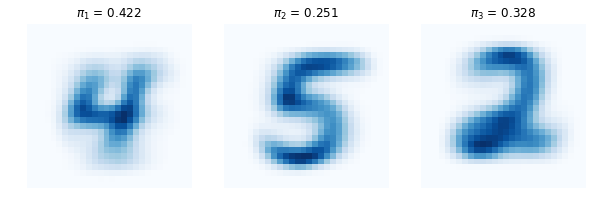

In [10]:
plt.figure(figsize=(10, 4))
for i, component_mean in enumerate(model.mu):
    plt.subplot(1, 3, i + 1)
    plt.imshow(component_mean.reshape((28, 28)), cmap='Blues')
    plt.title(r'$\pi_{:d}$ = {:.3f}'.format(i + 1, model.pi[i]))
    plt.axis('off')

We can see that the means correspond to the three digits in the dataset. In this particular case, given a value of 1 for the latent variable $\mathbf{z}$ (corresponding to digit 4), the observation (the image) is a sample from the distribution whose mean is given by the one to the left in the plots above. The mixing coefficients give us an idea of the proportion of instances of each digit in the dataset used to train the model.

As we have seen, introducing latent variables has allowed us to specify complex probability distributions that are likely to provide more predictive power in some applications. Other examples include mixtures of Gaussians for clustering applications, where usually an algorithm like K-means fails at capturing different covariances for each cluster; and non-trivial probabilistic models of real life data, such as click models [2].

It is important to note that the EM algorithm is not the ultimate way to find parameters of models with latent variables. On one hand, the method is sensitive to the initialization of the parameters and might end up at a local maximum of the log-likelihood. On the other hand, we have assumed that we can calculate the posterior $p(\mathbf{Z}\vert\mathbf{X},\boldsymbol{\theta})$, which sometimes is not possible for more elaborate models. In such cases it is necessary to resort to approximate methods such as sampling and variational inference. This last area leads to many recent advances, including the Variational Autoencoder, which I would like to discuss in the near feature.

### References

[1] Murphy, K. P. (2012). Machine Learning: A Probabilistic Perspective. The MIT Press.

[2] Dan Piponi, "Expectation-Maximization with Less Arbitrariness", blog post at [http://blog.sigfpe.com/2016/10/expectation-maximization-with-less.html](http://blog.sigfpe.com/2016/10/expectation-maximization-with-less.html).

[2] Chuklin, Aleksandr, Ilya Markov, and Maarten de Rijke. "Click models for web search." Synthesis Lectures on Information Concepts, Retrieval, and Services 7, no. 3 (2015): 1-115.